# Asian Option Pricing using Monte Carlo

This report presents the results of using Monte Carlo (MC) to price an Asian call option (for brevity of the report, the results for a put option have been omitted).

## Initial parameters

The following parameters are used for the simulation:

- Today's stock price S0 = 100
- Strike E = 100
- Time to expiry (T=t) = 1 year
- volatility = 20%
- constant risk-free interest rate r = 5%


In [80]:
%matplotlib inline
# Sets plot size in notebook
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (10, 6)

%run ../SAsianOption.py
# Above line runs the following function 
# dic = asian_option_simulator(S0=100., K=100., T=1.0, r=0.05, sigma=0.2, M=100, I=100, k=10)


EU V(T) = 10.0892013234
Asian AC_c(T) = 5.54659143575
Asian AC_d(T) = 5.49974029651
Asian GC_c(T) = 5.33383690461


## Stock Path Generation

We start by using MC to generate 100 stock price paths using the _Milstein_ convention. In this process we use the antithetic variance reduction technique which increases the statistics to compute the option price with minimal computational effort.

The below plot shows 100 of these paths:

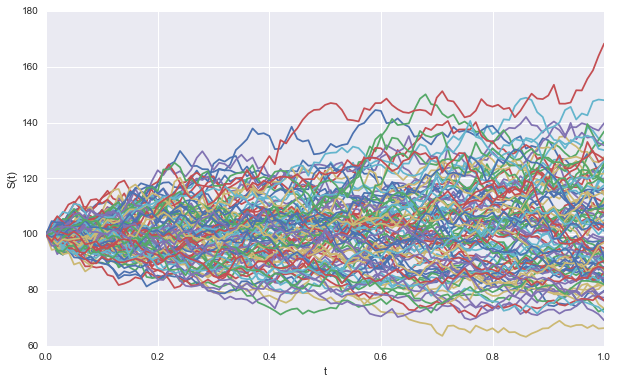

In [48]:
plt.plot(t_index, S_plus)
plt.ylabel("S(t)")
plt.xlabel("t")

## European Call Pricing

The same methodology is used to price a European Call option in order to compare to the Asian results later on. For the same input parameters above the following result is obtained:


In [49]:
print 'EU V(T) = {0}'.format(V)

EU V(T) = 10.0892013234


This yields the following Payoff plot at expiry (t=T), where the effect of the variance reduction technique is shown to boost the statistics to get a lower simulation error at little computing cost.

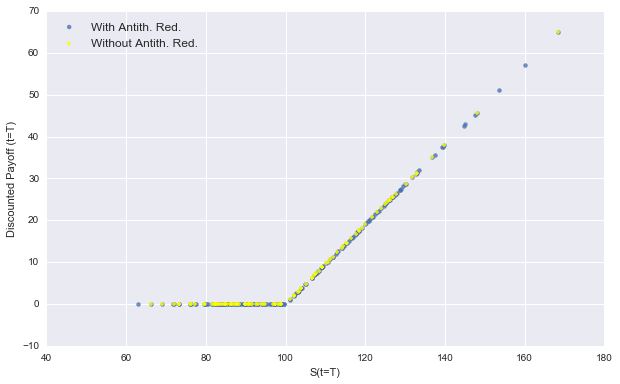

In [50]:
# V vs S plot without and with variance reduction
sns.regplot(x=S_join[-1], y=V_join[-1], fit_reg=False) # with antithetic correction
sns.regplot(x=S_plus[-1], y=V_plus[-1], fit_reg=False, color='yellow', marker='+') # without antithetic correction
plt.ylabel('Discounted Payoff (t=T)')
plt.xlabel('S(t=T)')
plt.legend(['With Antith. Red.', 'Without Antith. Red.'], loc='upper left', fontsize='large')

## Asian Call Pricing

The Asian Call value is then calculated using the same parameters above but with different methodologies to calculate the average of S:

- **Arithmetic** averaging using **both continuous** ('AC_c') and **discrete** ('AC_d') sampling
- **Geometric** averaging using **continuous** sampling **only** ('GC_c')

Note in the context of MC, we refer to 'continous sampling' when all the data points available up to that time are used, whereas 'discrete sampling' uses a sample determined by sampling frequency k (10 days in this case)


### Continuous vs Discrete Sampling

First let's understand the effects of continuous vs discrete sampling. For this purpose we restrict to the Arithmetic case only and assume the Geometric case observes the same behaviour.

Plotting one of the simulated stock paths and correspondinge arithmetic continuous and discrete averages (using a sampling frequency of 10 days), we get the following:

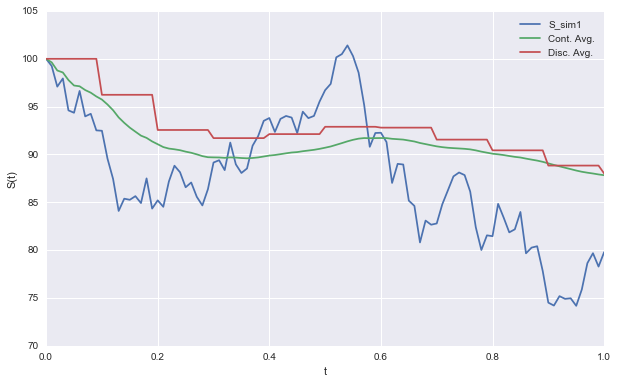

In [51]:
# S plot for MC, Arithmetic cont. and discrete averages
plt.plot(t_index, S_join[0:,0:1], label='S_sim1')
plt.plot(t_index, A_c_join[0:,0:1], label='Cont. Avg.')
plt.plot(t_index, A_d_join[0:,0:1], label='Disc. Avg.')
plt.ylabel('S(t)')
plt.xlabel('t')
plt.legend()


Hence we note that A_c and A_d differ slightly. This difference grows with the sampling frequency _k_ because for the same time to expiry we have less data points to calculate the average. This behaviour is show in the plot below where d_10 is more unstable than d_4, but as the number of data points increase, we expect the difference to get smaller and smaller, shown by the convergence trend close to expiry


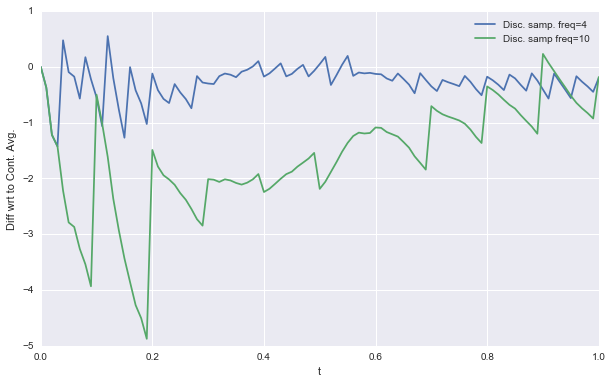

In [65]:
# Changing discrete sampling frequency from k=10 to k=4
dic2 = asian_option_simulator(S0=100., K=100., T=1.0, r=0.05, sigma=0.2, M=100, I=100, k=4)

# Calculate differences wrt continous case
d_10 = A_c_join - A_d_join
d_4 = A_c_join - dic2['A_d_join']

# Plot for just one simulation
plt.plot(t_index, d_4[0:,0:1], label='Disc. samp. freq=4')
plt.plot(t_index, d_10[0:,0:1], label='Disc. samp freq=10')
plt.ylabel('Diff wrt to Cont. Avg.')
plt.xlabel('t')
plt.legend()

However, for practical and legal reasons path-dependent quantities are never measured continuously. There is minimum time step between sampling since it is difficult to incorporate every single traded price into an average, for example, data can be unreliable and the exact time of a trade may not be known accurately.  

The option price also evolves with number of time steps to expiry and whether the average is calculated discretely or continously, as shown in the below plot:

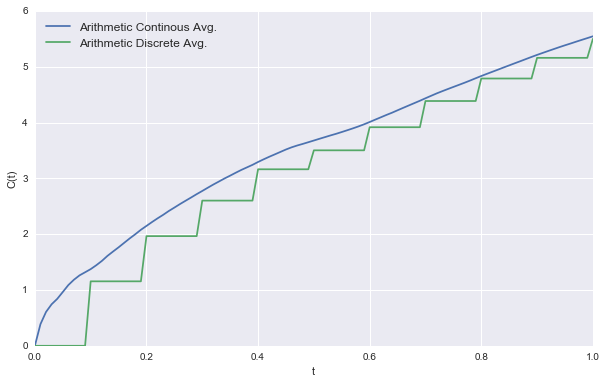

In [66]:
# Evolution of Asian Call value with number of time steps
c = AC_c_join.mean(axis=1)
d = AC_d_join.mean(axis=1)
plt.plot(t_index, c, label='Arithmetic Continous Avg.')
plt.plot(t_index, d, label='Arithmetic Discrete Avg.')
plt.ylabel('C(t)')
plt.xlabel('t')
plt.legend(loc='upper left', fontsize='large')

### Payoff function

The Payoff function at=T of the Asian call is also a lot more complex than it's European equivalent, which is expected given it's path-dependent nature. This justifies the need for using Monte Carlo methods for the pricing.

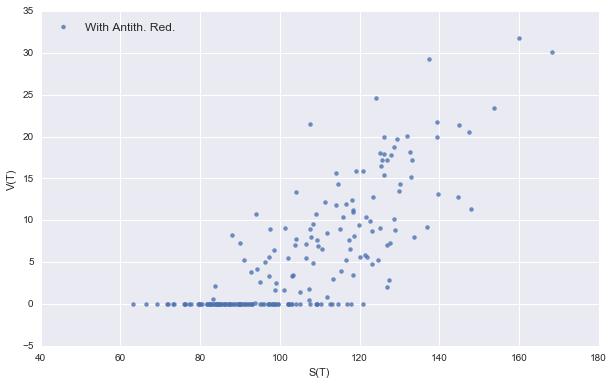

In [29]:
# # V vs S plot
sns.regplot(x=S_join[-1], y=AC_c_join[-1], fit_reg=False) # with antithetic correction
plt.ylabel('V(T)')
plt.xlabel('S(T)')
plt.legend(['With Antith. Red.'], loc='upper left', fontsize='large')

### Results and Errors

The results for this ATM option using above parameters are summarised below: 

In [79]:
df = pd.DataFrame(index=range(0,3), columns=['r', 'sigma', 'S', 'K', 'Type', 'V', 'AC_c', 'AC_d', 'GC_c'])
df.r = 0.05
df.sigma = 0.2
df.S = 100
df.loc[1, 'K'] = 100
df.loc[1, 'V'] = V
df.loc[1, 'Opt. Type'] = 'ATM'
df.loc[1, 'AC_c'] = AC_c
df.loc[1, 'AC_d'] = AC_d
df.loc[1, 'GC_c'] = GC_c
df[1:2]

,r,sigma,S,K,Type,V,AC_c,AC_d,GC_c,Opt. Type
1,0.05,0.2,100,100,NaN,10.0892,5.54659,5.49974,5.33384,ATM


This shows that for the same ATM option (S=K=100), the European Call (V) is considerably more expensive than the Asian equivalents.
